In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **FACIAL KEYPOINTS DETECTION**

In [42]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPool2D, Flatten
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import ReduceLROnPlateau
import seaborn as sns
import tensorflow as tf
from keras.layers import LeakyReLU
from keras.layers import Conv2D, Dropout,Dense, Flatten
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Conv2D, MaxPool2D, ZeroPadding2D
from keras.models import Sequential, Model

In [43]:
training = pd.read_csv('/content/drive/MyDrive/training.csv')
testing = pd.read_csv('/content/drive/MyDrive/test.csv')


In [4]:
training.shape


(1369, 31)

In [5]:
testing.shape

(1783, 2)

In [6]:
print(training.isna().sum())

left_eye_center_x             0
left_eye_center_y             0
right_eye_center_x            0
right_eye_center_y            0
left_eye_inner_corner_x       0
left_eye_inner_corner_y       0
left_eye_outer_corner_x       0
left_eye_outer_corner_y       0
right_eye_inner_corner_x      0
right_eye_inner_corner_y      0
right_eye_outer_corner_x      0
right_eye_outer_corner_y      0
left_eyebrow_inner_end_x      0
left_eyebrow_inner_end_y      0
left_eyebrow_outer_end_x      0
left_eyebrow_outer_end_y      0
right_eyebrow_inner_end_x     0
right_eyebrow_inner_end_y     0
right_eyebrow_outer_end_x     0
right_eyebrow_outer_end_y     0
nose_tip_x                    0
nose_tip_y                    0
mouth_left_corner_x           0
mouth_left_corner_y           0
mouth_right_corner_x          0
mouth_right_corner_y          0
mouth_center_top_lip_x        0
mouth_center_top_lip_y        0
mouth_center_bottom_lip_x    11
mouth_center_bottom_lip_y    11
Image                         0
dtype: i

In [7]:
training.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


In [8]:
testing.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [9]:
  training.isnull().any().value_counts()

,count
False,29
True,2


In [10]:
training.fillna(method = 'ffill', inplace = True)
training.isnull().any().value_counts()

<ipython-input-10-c2348a6e4214>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  training.fillna(method = 'ffill', inplace = True)


,count
False,31


In [11]:
def process_img(data):
    images = []
    for idx, sample in data.iterrows():
        pixels = sample['Image'].split(' ')
        if len(pixels) == 96 * 96:
            image = np.array(pixels, dtype=int)
            image = np.reshape(image, (96, 96, 1))
            images.append(image)
        else:
            print(f"Skipping row {idx} due to incorrect pixel count: {len(pixels)}")
    images = np.array(images) / 255.
    return images


In [12]:
def keypoints(data) :
  keypoint = data.drop('Image', axis = 1)
  keypoint_features = []
  for idx, sample_keypoints in keypoint.iterrows() :
    keypoint_features.append(sample_keypoints)
  keypoint_features = np.array(keypoint_features, dtype = 'float')
  return keypoint_features

In [13]:
y_test = testing.Image
y_test.head()

,Image
0,182 183 182 182 180 180 176 169 156 137 124 10...
1,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,177 176 174 170 169 169 168 166 166 166 161 14...
3,176 174 174 175 174 174 176 176 175 171 165 15...
4,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [14]:
x_train = process_img(training)
y_train = keypoints(training)

Skipping row 1368 due to incorrect pixel count: 4023


Skipping row 1368 due to incorrect pixel count: 4023


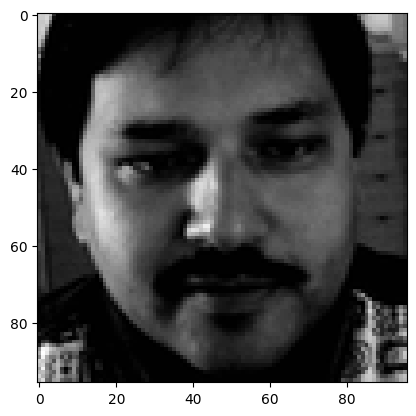

In [15]:
 plt.imshow(process_img(training)[200].reshape(96,96), cmap = 'gray')
 plt.show()

In [16]:
def image_with_keypoints(df, index) :
  image = plt.imshow(x_train[index], cmap = 'gray')
  l = []
  for i in range(1, 31, 2) :
    l.append(plt.plot(y_train[index][i-1], y_train[index][i], 'ro'))
  return image, l

(<matplotlib.image.AxesImage at 0x7d4d66066e00>,
 [[<matplotlib.lines.Line2D at 0x7d4d661e44c0>],
  [<matplotlib.lines.Line2D at 0x7d4d645386a0>]])

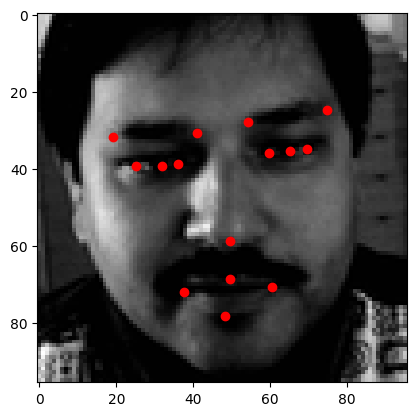

In [17]:
 image_with_keypoints(training, 200)

(<matplotlib.image.AxesImage at 0x7d4d64eb35e0>,
 [[<matplotlib.lines.Line2D at 0x7d4d6614d990>],
  [<matplotlib.lines.Line2D at 0x7d4d64eb7c70>]])

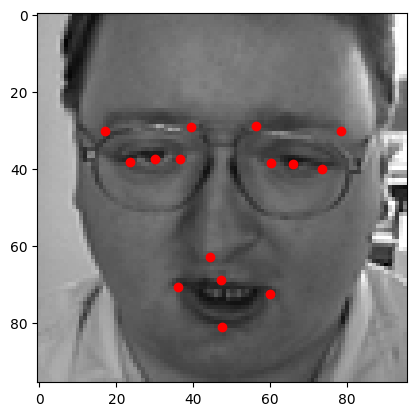

In [18]:
image_with_keypoints(x_train, 110)

(<matplotlib.image.AxesImage at 0x7d4d6619d5d0>,
 [[<matplotlib.lines.Line2D at 0x7d4d66563940>],
  [<matplotlib.lines.Line2D at 0x7d4d65fae950>]])

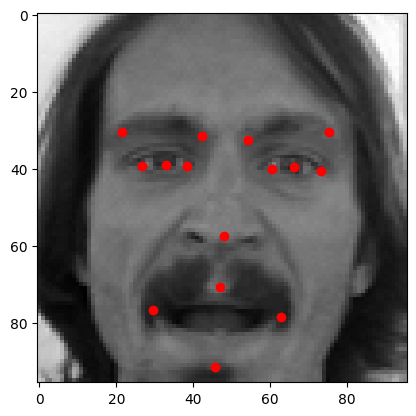

In [19]:
image_with_keypoints(x_train, 324)

(<matplotlib.image.AxesImage at 0x7d4d664ee140>,
 [[<matplotlib.lines.Line2D at 0x7d4d65fca0b0>],
  [<matplotlib.lines.Line2D at 0x7d4d65fcab90>]])

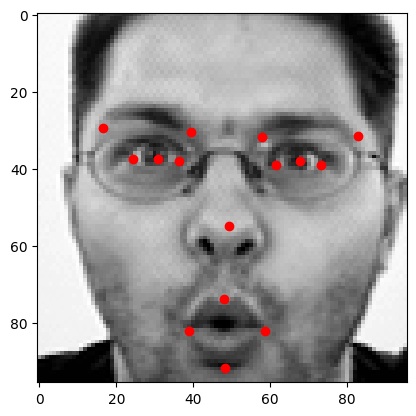

In [20]:
 image_with_keypoints(x_train, 570)

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPool2D, Flatten, BatchNormalization, Dense
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
import tensorflow.keras.backend as K
from keras.metrics import RootMeanSquaredError
from keras.callbacks import EarlyStopping


In [22]:
from tensorflow.keras import layers

img_size = 96

inputs = layers.Input(shape=(img_size, img_size, 1))
x = layers.Conv2D(128, (3,3), activation = 'relu', padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(128, (3,3), activation = 'relu', padding="same")(x)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(64, (3,3), activation = 'relu', padding="same")(x)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(32, (3,3), activation = 'relu', padding="same")(x)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Flatten()(x)

x = layers.Dense(256, activation = 'relu')(x)
x = layers.Dropout(0.1)(x)

x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(30)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 96, 96, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 96, 96, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 574,462 (2.19 MB)

 Trainable params: 573,758 (2.19 MB)

 Non-trainable params: 704 (2.75 KB)

In [23]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer = 'Adam', loss = 'mae', metrics = [rmse])
earlystop_callback = EarlyStopping(monitor = 'val_rmse', patience = 20, restore_best_weights= True, mode = 'min')
history = model.fit(x_train, y_train, batch_size = 32, epochs = 100, validation_split = 0.2, callbacks = [earlystop_callback])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - loss: 4.3949 - rmse: 5.5284 - val_loss: 6.6468 - val_rmse: 7.6400
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 3.0762 - rmse: 3.9995 - val_loss: 5.4844 - val_rmse: 6.4175
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.9865 - rmse: 3.9062 - val_loss: 5.5590 - val_rmse: 6.4966
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 3.0889 - rmse: 4.0802 - val_loss: 3.4186 - val_rmse: 4.2637
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 3.1993 - rmse: 4.1593 - val_loss: 5.3352 - val_rmse: 6.3068
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.9908 - rmse: 3.8852 - val_loss: 3.7556 - val_rmse: 4.7533
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 3.1060 - rmse: 4.0542 - val_loss: 4.4956 - val_rmse: 5.4301
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.8793 - rmse: 3.7818 - val_loss: 5.2284 - val_rmse: 6.2135
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━

In [26]:
 x_test = process_img(testing)
 y_pred = model.predict(x_test)

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step


In [27]:
def image_with_keypoints(df, index) :
  image = plt.imshow(x_test[index], cmap = 'gray')
  l = []
  for i in range(1, 31, 2) :
    l.append(plt.plot(y_pred[index][i-1], y_pred[index][i], 'ro'))
  return image, l

(<matplotlib.image.AxesImage at 0x7d4d64528490>,
 [[<matplotlib.lines.Line2D at 0x7d4d66033b20>],
  [<matplotlib.lines.Line2D at 0x7d4d67536c50>]])

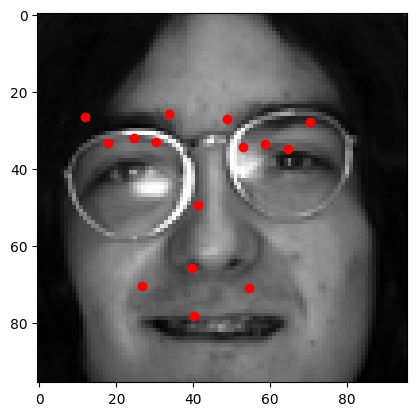

In [28]:
image_with_keypoints(x_test, 350)

(<matplotlib.image.AxesImage at 0x7d4d50236710>,
 [[<matplotlib.lines.Line2D at 0x7d4d501f38b0>],
  [<matplotlib.lines.Line2D at 0x7d4d503c56f0>]])

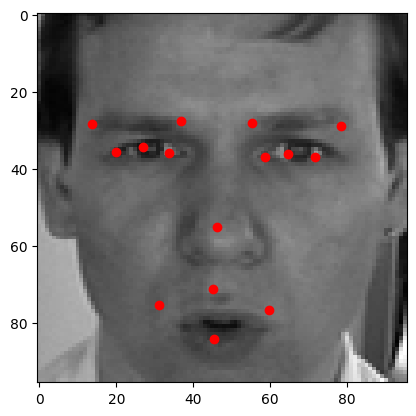

In [29]:
image_with_keypoints(x_test, 50)

(<matplotlib.image.AxesImage at 0x7d4d65fd9000>,
 [[<matplotlib.lines.Line2D at 0x7d4d673cfc70>],
  [<matplotlib.lines.Line2D at 0x7d4d65d19f90>]])

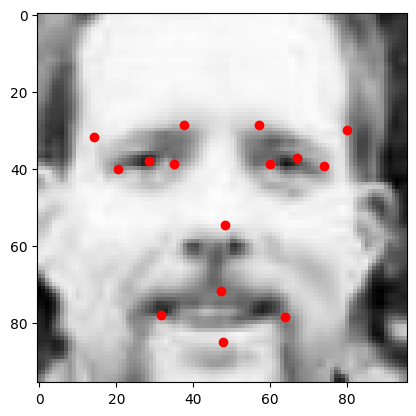

In [30]:
image_with_keypoints(x_test, 780)

In [39]:
inputs = layers.Input(shape=(img_size, img_size, 1))

x = layers.Conv2D(512, (3,3), activation = 'relu', padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(256, (3,3), activation = 'relu', padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(128, (3,3), activation = 'relu', padding="same")(x)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(64, (3,3), activation = 'relu', padding="same")(x)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Conv2D(32, (3,3), activation = 'relu', padding="same")(x)
x = layers.Dropout(0.1)(x)
x = layers.MaxPool2D((2,2))(x)

x = layers.Flatten()(x)

x = layers.Dense(256, activation = 'relu')(x)
x = layers.Dropout(0.1)(x)

x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(30)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 96, 96, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 96, 96, 512)         │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 96, 96, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 48, 48, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 48, 48, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 48, 48, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 24, 24, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 12, 12, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 6, 6, 32)            │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 3, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 288)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,686,910 (6.44 MB)

 Trainable params: 1,684,990 (6.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer = 'Adam', loss = 'mae', metrics = [rmse])

history = model.fit(x_train, y_train, batch_size = 32, epochs = 100, validation_split = 0.2, callbacks = [earlystop_callback])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 297ms/step - loss: 5.7694 - rmse: 7.2502 - val_loss: 5.3716 - val_rmse: 6.4375
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 4.6750 - rmse: 6.0058 - val_loss: 2.6330 - val_rmse: 3.4087
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 4.7631 - rmse: 6.1611 - val_loss: 3.0618 - val_rmse: 3.9005
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 4.4594 - rmse: 5.7027 - val_loss: 2.6559 - val_rmse: 3.4608
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 4.2927 - rmse: 5.5439 - val_loss: 5.5253 - val_rmse: 6.6124
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 4.3097 - rmse: 5.5690 - val_loss: 3.8345 - val_rmse: 4.8114
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 4.2216 - rmse: 5.4653 - val_loss: 2.9681 - val_rmse: 3.9080
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 4.3783 - rmse: 5.6170 - val_loss: 5.7541 - val_rmse: 6.8143
Epoch 9/100
35/35 ━━━━━━━━━━━━━